# Experiment 4: fire January set + HRRR

This notebook focuses on running Experiment 4, which uses data from January (no-fire period) combining PWWB, AirNow, and HRRR datasets.

# Data parameters

In [1]:
# define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 200
frames_per_sample = 5
 
# date range of data - two weeks of January for this Experiment 4024-12-08-00", "2024-12-21-00"
jan_start_date, jan_end_date = "2025-01-01-00", "2025-02-01-00"

# Data ingestion and preprocessing

In [2]:
# python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData

# Import the HRRR data class
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

/home/moh/miniconda3/envs/hysplitrevised/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create output directory for results
output_dir = "experiment_output"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file="experiment4_registry.json",
    cache_dir="data/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Existing datasets:


name                     created  \
0  jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY  2025-05-22T09:37:31.972532   

                                         description     start_date  \
0  January 2024 - two weeks with MAIAC, TROPOMI N...  2025-01-01-00   

        end_date               channels  
0  2025-02-01-00  maiac, tropomi, metar

In [4]:
# Adjust end date for AirNow
jan_end_date_adj = pd.to_datetime(jan_end_date) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = "jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY"
dataset_desc = "January 2024 - two weeks with MAIAC, TROPOMI NO2, METAR Wind U/V components only"

# ========== 1. Load January PWWB Data ==========
print("\nLoading January PWWB data...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    jan_pwwb = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    jan_pwwb = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=jan_start_date,
        end_date=jan_end_date,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': True,                     # Include MAIAC AOD
            'tropomi': ['TROPOMI_NO2'],        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    jan_pwwb.save_data()

# Get the data and channel info
X_jan_pwwb = jan_pwwb.data
channel_info = jan_pwwb.get_channel_info()
print(f"✓ January PWWB data shape: {X_jan_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")

# ========== 2. Load January AirNow Data ==========
print("\nLoading January AirNow data...")
jan_airnow = AirNowData(
    start_date=jan_start_date,
    end_date=jan_end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    force_reprocess=False
)
X_jan_airnow = jan_airnow.data
Y_jan = jan_airnow.target_stations
print(f"✓ January AirNow data shape: {X_jan_airnow.shape}")
if Y_jan is not None:
    print(f"  January target stations shape: {Y_jan.shape}")
else:
    print("  No January target stations available")

# ========== 3. Load January HRRR Data ==========
print("\nLoading January HRRR data...")
jan_hrrr = HRRRData(
    start_date=jan_start_date,
    end_date=jan_end_date,
    extent=extent,
    extent_name='la_region',
    product='COLMD',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True,
    sample_setting=2
)
# Convert units from kg to micrograms (1e9)
X_jan_hrrr = jan_hrrr.data
print(f"✓ January HRRR data shape: {X_jan_hrrr.shape}")


Loading January PWWB data...
Dataset 'jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY' already exists, loading from cache...
Using cache prefix: jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY_
Initialized PWWBData with 744 hourly timestamps
Date range: 2025-01-01 00:00:00 to 2025-01-31 23:00:00
Channels included: ['maiac', 'tropomi', 'metar']
TROPOMI channels: ['TROPOMI_NO2']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing MAIAC AOD data...
Loading cached MAIAC AOD data from data/pwwb_cache/jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY_maiac_aod_data.npy


/home/moh/wildfire/hrrr-smoke-viz/pwwb-experiments/../libs/pwwb/pwwb_data.py:115: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.timestamps = pd.date_range(self.start_date, self.end_date, freq='H')


Processing TROPOMI data...
Including TROPOMI channels: ['TROPOMI_NO2']
Loading cached TROPOMI data from data/pwwb_cache/jan2024_MAIC_TROPOMI_N02_METAR_WIND_UV_ONLY_tropomi_no2_data.npy
Processing METAR meteorological data...
Initialized MetarDataSource with 2 channels: ['METAR_Wind_U', 'METAR_Wind_V']
Will fetch these raw variables: ['sped', 'drct']
Will calculate wind U/V components from speed/direction
Including METAR variables: ['sped', 'drct']
Preparing data for channels: ['METAR_Wind_U', 'METAR_Wind_V']
Using 10 METAR stations for meteorological data:
  LAX - Los Angeles Intl (33.9382, -118.3865)
  BUR - Burbank/Glendale (34.2007, -118.3587)
  LGB - Long Beach Airport (33.8118, -118.1472)
  VNY - Van Nuys Airport (34.2097, -118.4892)
  SMO - Santa Monica Muni (34.021, -118.4471)
  HHR - Hawthorne Municipal (33.9228, -118.3352)
  EMT - El Monte (34.086, -118.035)
  SNA - Santa Ana/John Wayne (33.6757, -117.8682)
  ONT - Ontario Intl (34.056, -117.6012)
  CQT - Los Angeles Downtown/

Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_07e4105b__hrrr.t04z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_07214941__hrrr.t04z.wrfsfcf02.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_07154941__hrrr.t04z.wrfsfcf03.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_074b4941__hrrr.t04z.wrfsfcf04.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_071a4941__hrrr.t04z.wrfsfcf05.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_7ce4105b__hrrr.t05z.wrfsfcf01.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_region_subset_7c214941__hrrr.t05z.wrfsfcf02.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/moh/data/hrrr/20250101/la_re

✓ January HRRR data shape: (740, 5, 200, 200, 1)


In [5]:
# ========== 4. Create Experiment 4 dataset ==========
print("\nCreating Experiment 4 dataset...")

# Experiment 4: No-fire January set + HRRR
print("  Experiment 4: No-fire January set + HRRR")
X_exp2 = np.concatenate([X_jan_pwwb, X_jan_airnow, X_jan_hrrr], axis=-1)
print(f"    Combined shape: {X_exp2.shape}")

# Display the number of channels from each source
pwwb_channels = X_jan_pwwb.shape[4]
airnow_channels = X_jan_airnow.shape[4]
hrrr_channels = X_jan_hrrr.shape[4]
print(f"    PWWB channels: {pwwb_channels}, AirNow channels: {airnow_channels}, HRRR channels: {hrrr_channels}, Total: {X_exp2.shape[4]}")


Creating Experiment 4 dataset...
  Experiment 4: No-fire January set + HRRR
    Combined shape: (740, 5, 200, 200, 6)
    PWWB channels: 4, AirNow channels: 1, HRRR channels: 1, Total: 6


In [6]:
# ========== 5. Train/Test Split for experiment ==========
print("\nCreating train/test splits for experiment...")
# Experiment 4 splits
X_exp2_train, X_exp2_test = train_test_split(X_exp2, train_size=0.75)
Y_jan_train, Y_jan_test = train_test_split(Y_jan, train_size=0.75)
print(f"  Experiment 4: Train={X_exp2_train.shape}, Test={X_exp2_test.shape}")

# ========== 6. Standardize data ==========
print("\nStandardizing data...")

# Experiment 4 standardization
X_exp2_train_scaled, X_exp2_test_scaled = std_scale(X_exp2_train, X_exp2_test)
print(f"  Experiment 4: Scaled train={X_exp2_train_scaled.shape}, test={X_exp2_test_scaled.shape}")


Creating train/test splits for experiment...
  Experiment 4: Train=(555, 5, 200, 200, 6), Test=(185, 5, 200, 200, 6)

Standardizing data...
  Experiment 4: Scaled train=(555, 5, 200, 200, 6), test=(185, 5, 200, 200, 6)


In [7]:
# ========== 7. Save prepared datasets ==========
print("\nSaving prepared dataset...")

# Create directory for experiment
exp_dir = os.path.join(output_dir, "experiment4")
os.makedirs(exp_dir, exist_ok=True)

# Save Experiment 4 data
np.save(os.path.join(exp_dir, "X_train.npy"), X_exp2_train_scaled)
np.save(os.path.join(exp_dir, "X_test.npy"), X_exp2_test_scaled)
np.save(os.path.join(exp_dir, "y_train.npy"), Y_jan_train)
np.save(os.path.join(exp_dir, "y_test.npy"), Y_jan_test)

# Save metadata
metadata = {
    "date_range": f"{jan_start_date} to {jan_end_date}",
    "extent": extent,
    "dim": dim,
    "frames_per_sample": frames_per_sample,
    "pwwb_channels": channel_info['channel_names'],
    "airnow_channels": ["AirNow_PM25"],
    "hrrr_channels": ["HRRR_COLMD"]
}

with open(os.path.join(exp_dir, "metadata.json"), "w") as f:
    import json
    json.dump(metadata, f, indent=2)

print("\n✓ Dataset prepared and saved!")


Saving prepared dataset...

✓ Dataset prepared and saved!


# Data visualization

Visualizing data...


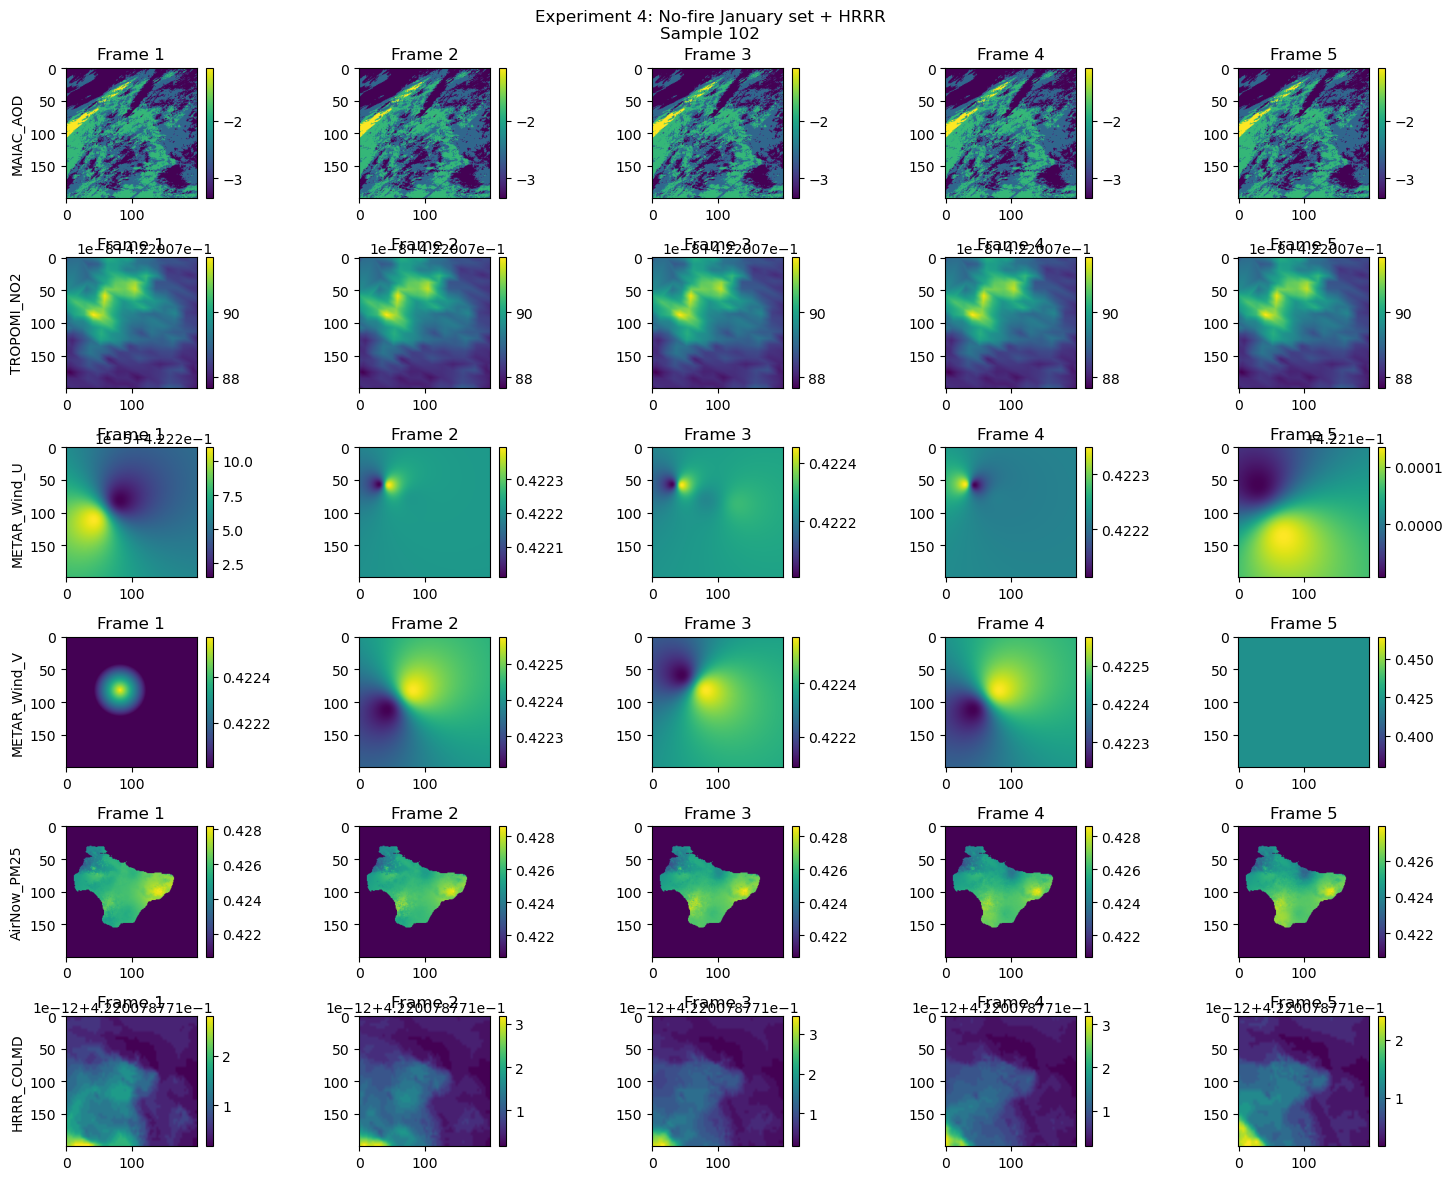

Target values: [ 2.7  2.2  8.7 22.2 24.2 42.2 35.7 28.3  3.  45.4 25.1 27.2  8.7  1.9
  9.9]


In [8]:
# Function to visualize data from experiment
def visualize_experiment_data(X, y, channel_names=None, sample_idx=None):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        for f in range(n_frames):
            ax = axes[c, f]
            im = ax.imshow(X[sample_idx, f, :, :, c])
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_names[c])
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"Experiment 4: No-fire January set + HRRR\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if y is not None:
        print(f"Target values: {y[sample_idx]}")

# Create combined channel names list
all_channel_names = channel_info['channel_names'] + ["AirNow_PM25"] + ["HRRR_COLMD"]

# Visualize a sample from the experiment
print("Visualizing data...")
visualize_experiment_data(X_exp2_train_scaled, Y_jan_train, channel_names=all_channel_names)

# Model

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

2025-05-22 11:11:02.037543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 11:11:02.354346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-22 11:11:04.227520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



==== Running Experiment 4: No-fire January set + HRRR ====
Training data shape: (555, 5, 200, 200, 6)
Target data shape: (555, 15)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 200, 200,    │        11,400 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 200, 200,    │        48,720 │
│                                 │ 30)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 200, 200,    │        12,165 │
│                                 │ 15)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 200, 200, 1) │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │     3,000,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,072,706 (11.72 MB)

 Trainable params: 3,072,706 (11.72 MB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - loss: 12.1418 - val_loss: 7.5319
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 410ms/step - loss: 10.2950 - val_loss: 7.7003
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 404ms/step - loss: 9.3008 - val_loss: 6.9682
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 403ms/step - loss: 8.5244 - val_loss: 6.2591
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 415ms/step - loss: 8.6289 - val_loss: 6.8607
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 405ms/step - loss: 8.8274 - val_loss: 6.2148
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 411ms/step - loss: 9.1513 - val_loss: 6.1641
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 409ms/step - loss: 9.2699 - val_loss: 6.2878
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 401ms/step - loss: 8.4326 - val_loss: 6.6917
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 402ms/step - loss: 8.0612 - val_loss: 6.3640
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 44s 396ms/step - loss: 8.3065 - val_

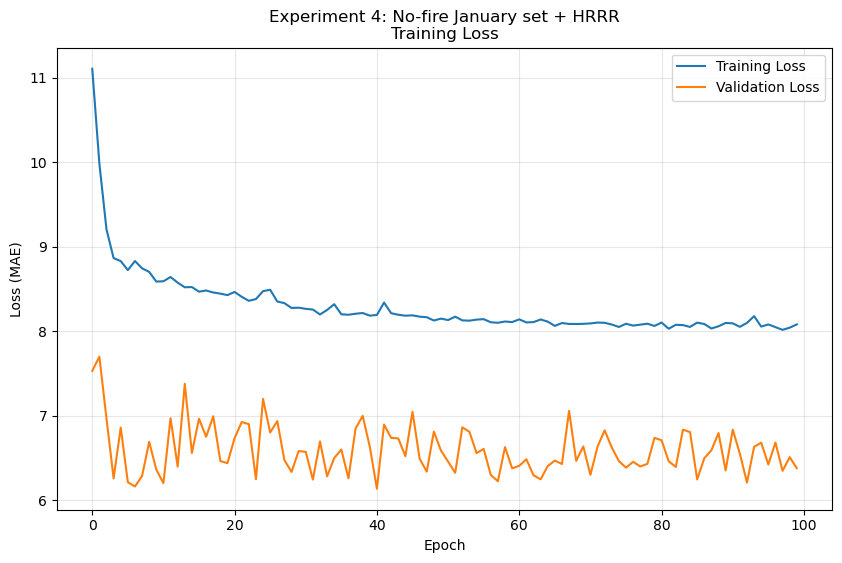

In [10]:
# Run Experiment 4: No-fire January set + HRRR
print("\n==== Running Experiment 4: No-fire January set + HRRR ====")
print(f"Training data shape: {X_exp2_train_scaled.shape}")
print(f"Target data shape: {Y_jan_train.shape}")

# Build model
seq = Sequential()

seq.add(
    InputLayer(shape=X_exp2_train_scaled.shape[1:])
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())
seq.add(Dense(Y_jan_train.shape[1], activation='relu'))

# Compile model
seq.compile(loss='mean_absolute_error', optimizer='adam')

# Print model summary
seq.summary()

# Train model
print(f"\nTraining model...")
epochs = 100 
batch_size = 4
history = seq.fit(
    X_exp2_train_scaled, Y_jan_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

# Evaluate model
print(f"\nEvaluating model...")
test_loss = seq.evaluate(X_exp2_test_scaled, Y_jan_test, verbose=0)
print(f"Test MAE: {test_loss:.4f}")

# Make predictions
y_pred = seq.predict(X_exp2_test_scaled, verbose=0)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(Y_jan_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_jan_test, y_pred))
r2 = r2_score(Y_jan_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
plt.title('Experiment 4: No-fire January set + HRRR\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results
results_dir = os.path.join(output_dir, "experiment4", "results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
seq.save(os.path.join(results_dir, "model.h5"))

exp2_results = {
    'model': seq,
    'history': history,
    'loss': test_loss,
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'y_pred': y_pred,
    'y_test': Y_jan_test
}

# Evaluate

In [11]:
print(f"\nDetailed analysis for Experiment 4:")
X_test = X_exp2_test_scaled
y_test = Y_jan_test
y_pred = exp2_results['y_pred']
model = exp2_results['model']
description = "No-fire January set + HRRR, two weeks"

print(f"Analyzing Experiment 4: {description}")


Detailed analysis for Experiment 4:
Analyzing Experiment 4: No-fire January set + HRRR, two weeks



1. Plotting prediction comparison...


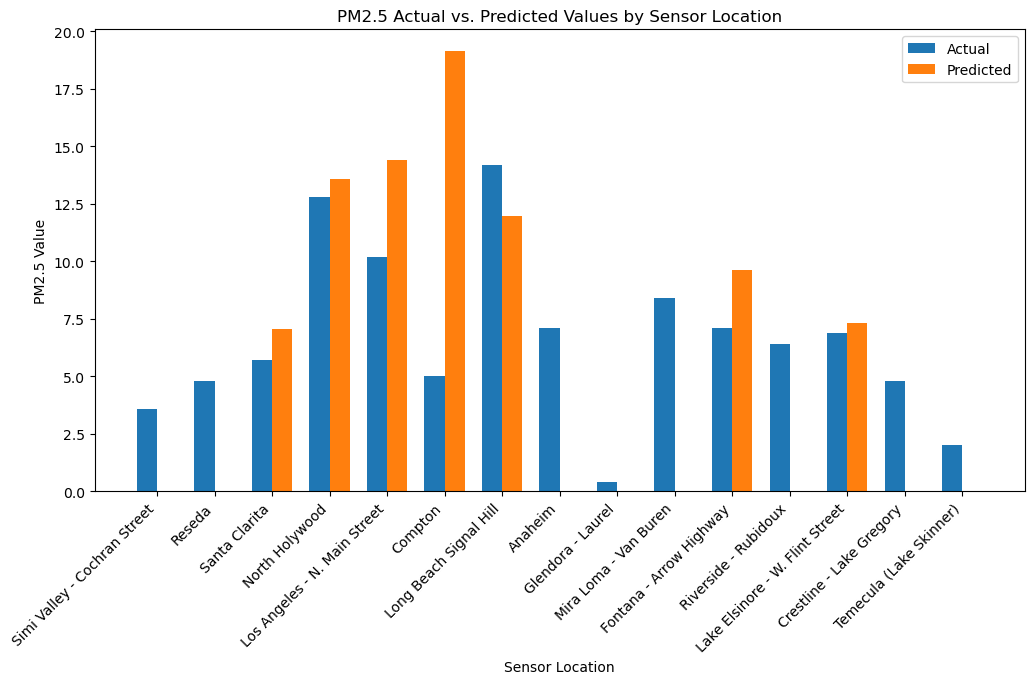


2. Plotting scatter comparison...


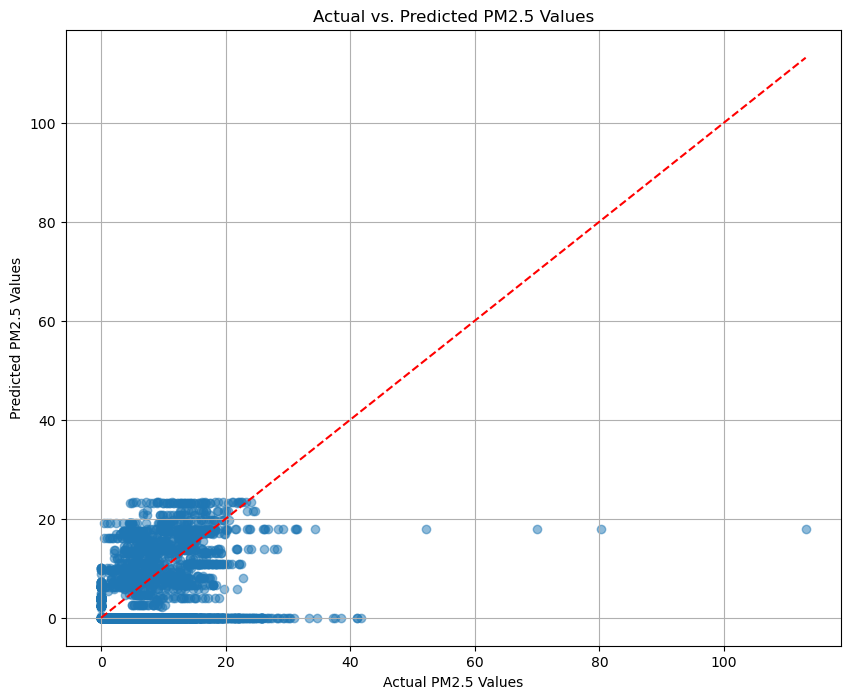


3. Plotting error by sensor...


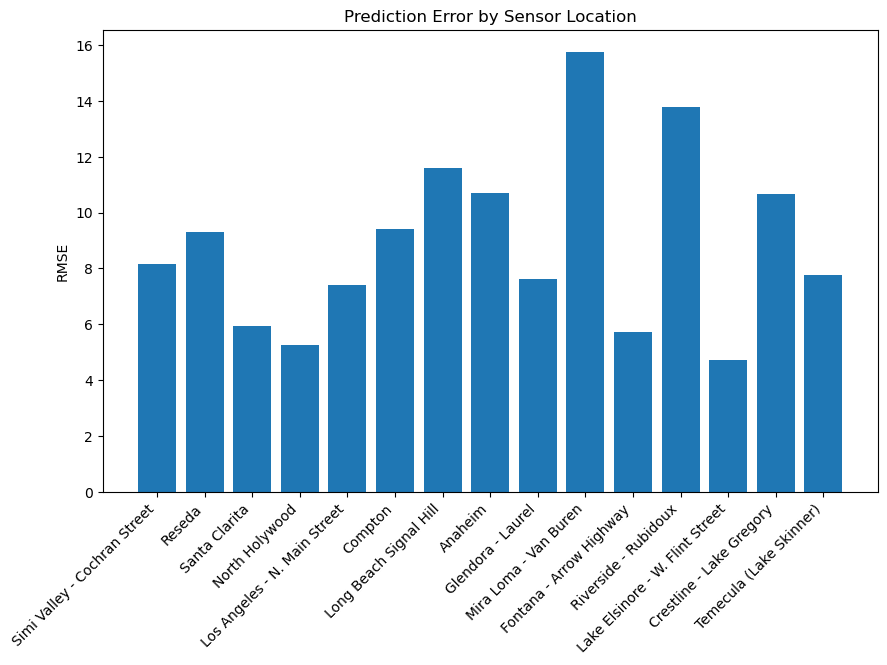


4. Plotting time series comparison...


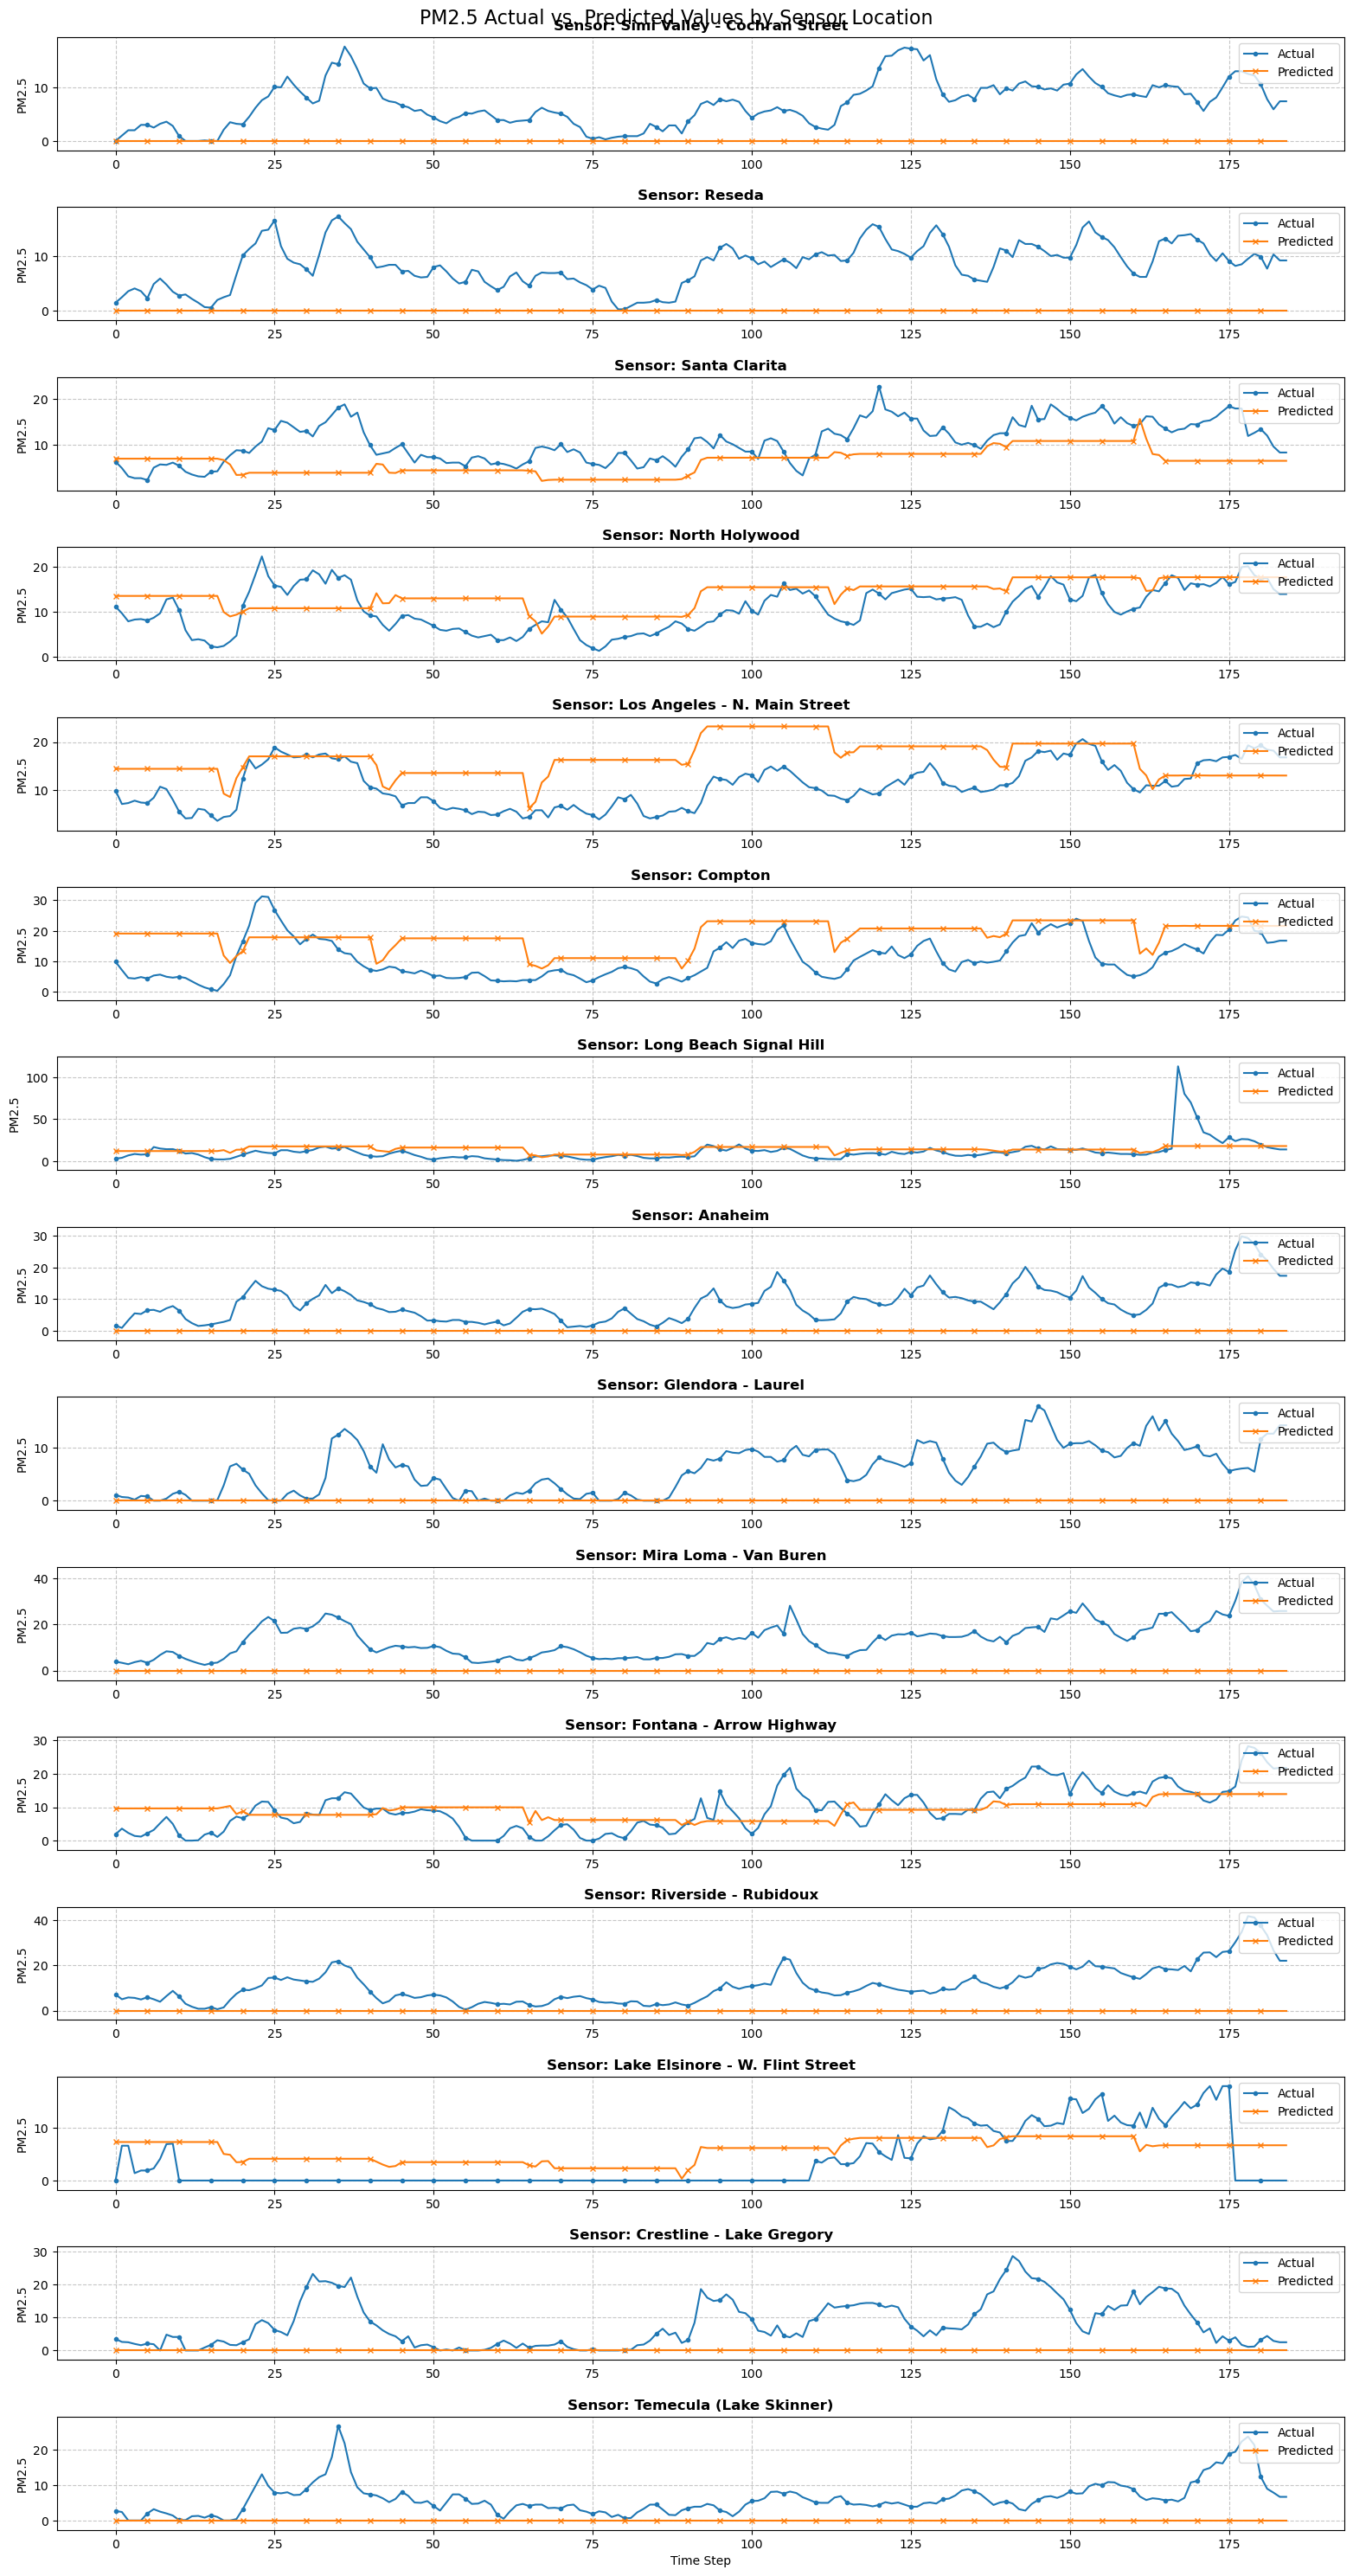


5. Plotting time series with shifted predictions...


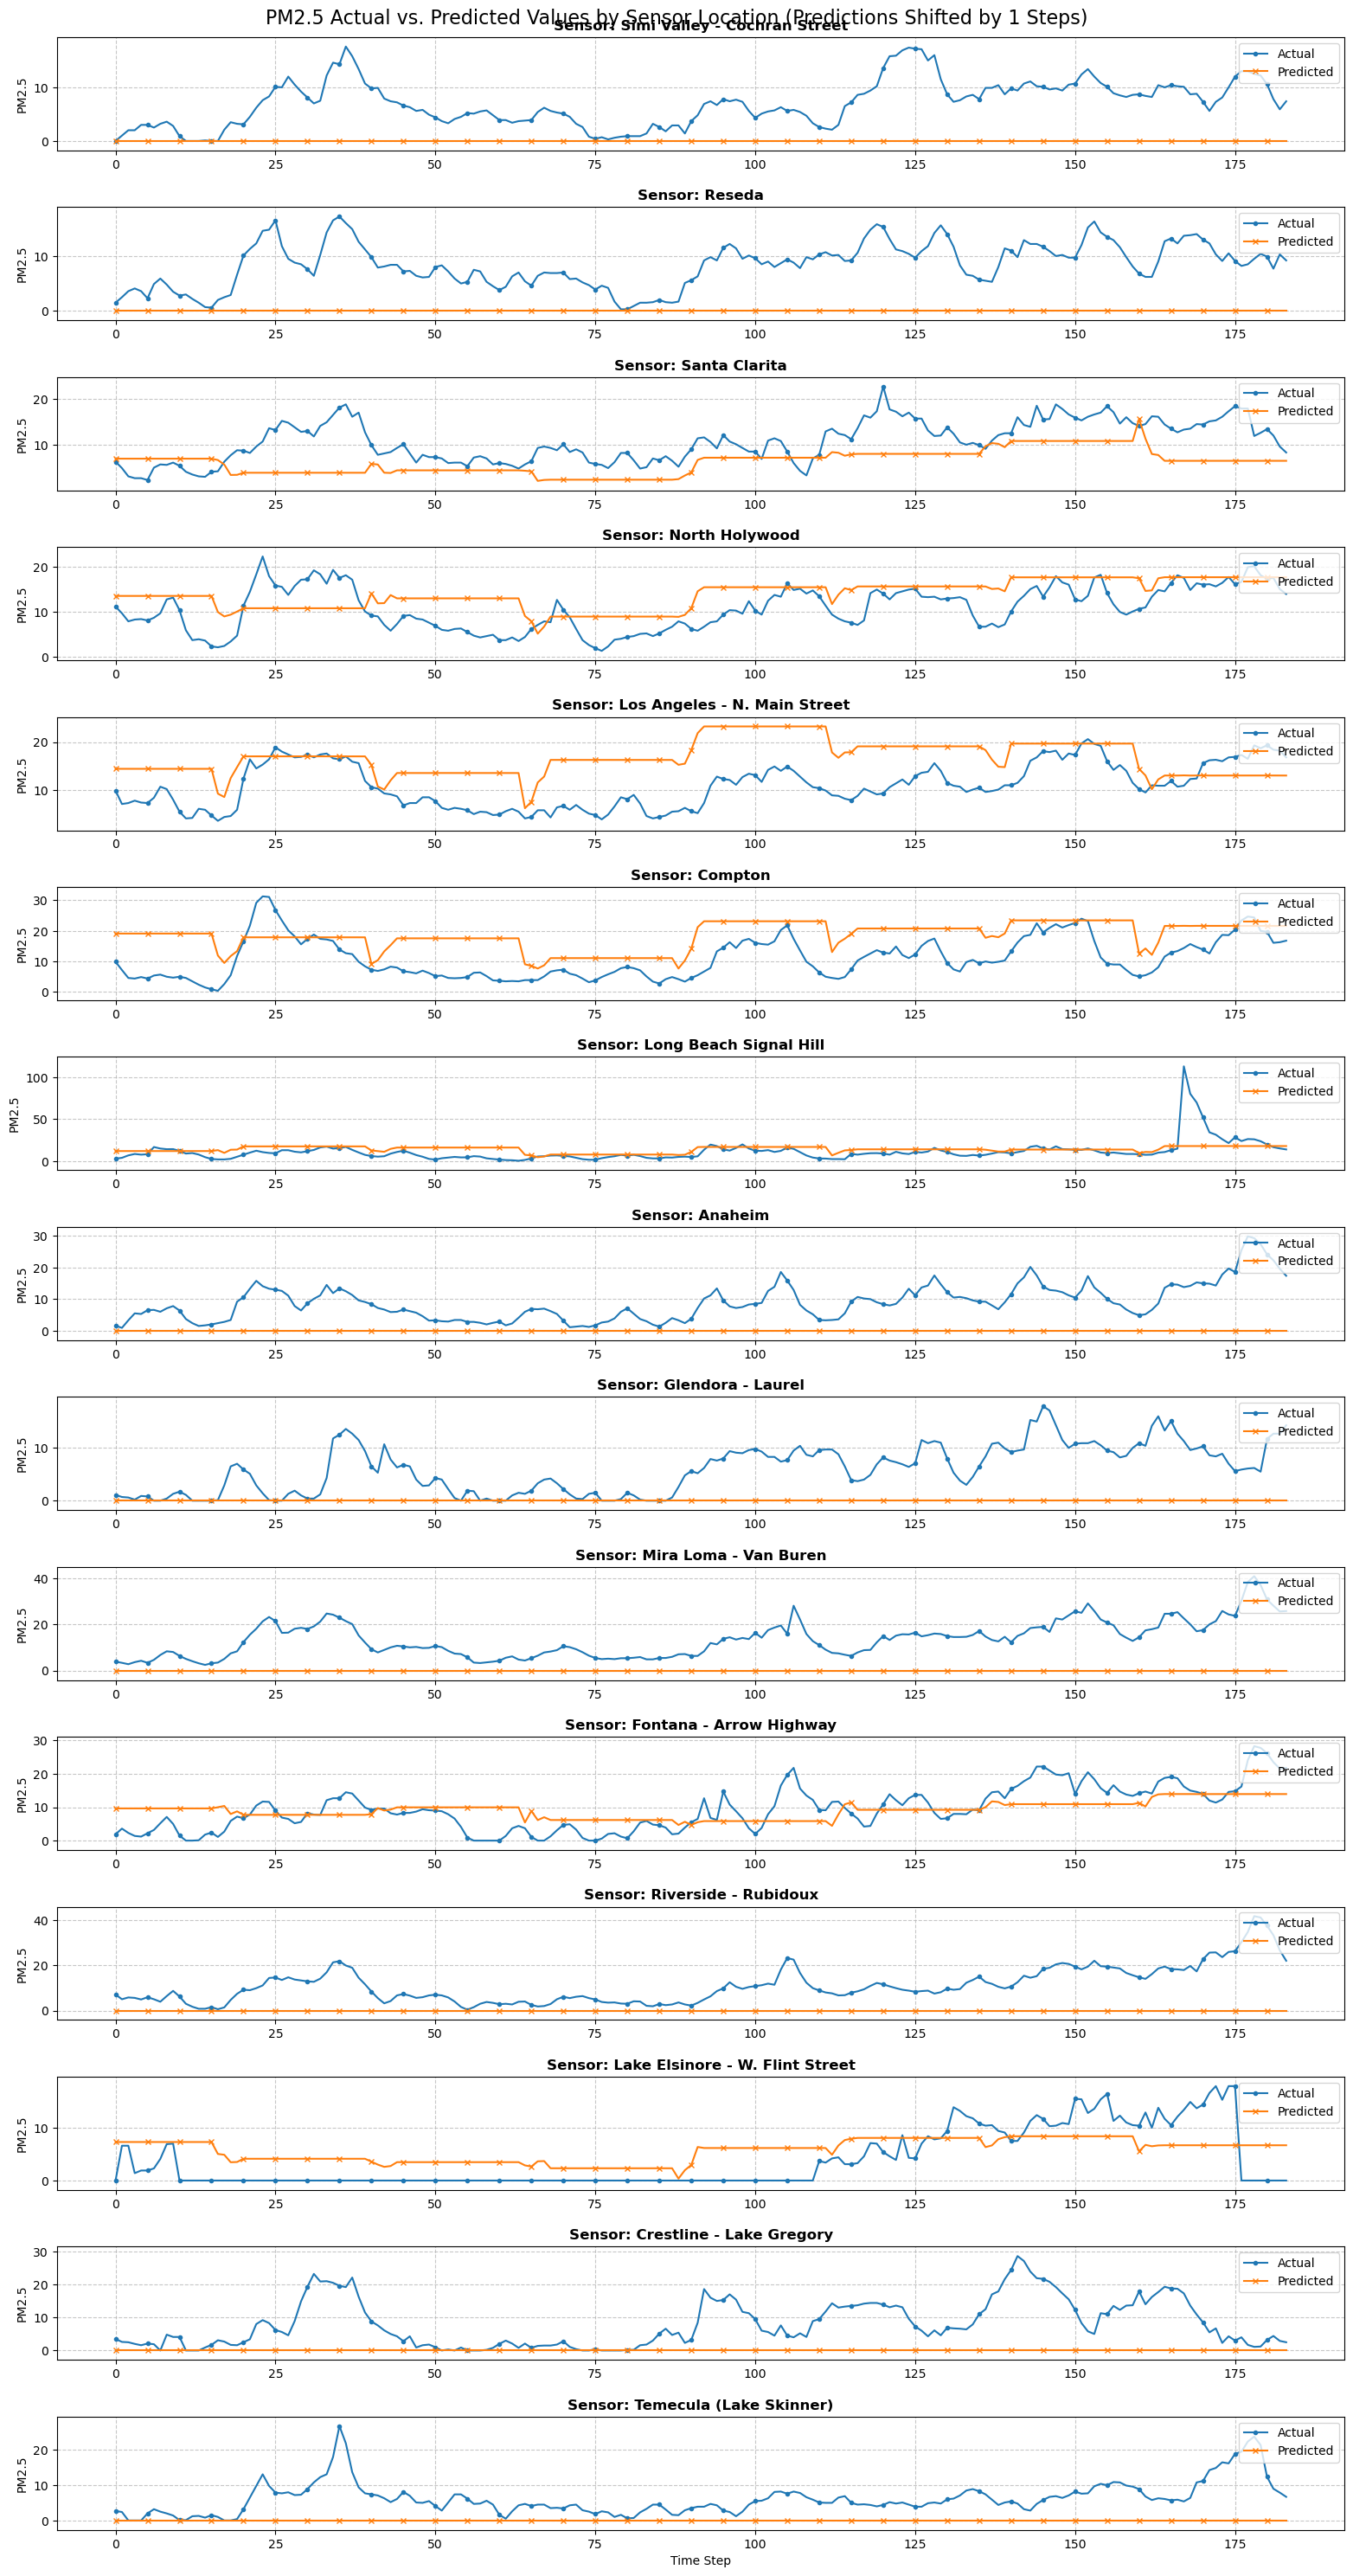


6. Printing metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 9.42
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 102.41%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 5.16
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 121.63%

Frame 2 (Hour 2) All Locations - Raw RMSE: 5.00
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 121.81%

Frame 3 (Hour 3) All Locations - Raw RMSE: 5.58
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 141.05%

Frame 4 (Hour 4) All Locations - Raw RMSE: 5.90
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 153.37%

Frame 5 (Hour 5) All Locations - Raw RMSE: 5.84
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 151.31%

Frame 6 (Hour 6) All Locations - Raw RMSE: 5.95
Frame 6 (Hour 6) All Loca

In [12]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Sensor names (use AirNow sensor names if available)
if hasattr(jan_airnow, 'sensor_names') and jan_airnow.sensor_names is not None:
    sensor_names = jan_airnow.sensor_names
else:
    sensor_names = [
        "North Holywood", 
        "Los Angeles - N. Main Street", 
        "Compton",
        "Crestline - Lake Gregory",
        "Fontana - Arrow Highway",
        "Glendora - Laurel",
        "Lake Elsinore - W. Flint Street",
        "Long Beach Signal Hill",
        "Mira Loma - Van Buren",
        "Reseda",
        "Riverside - Rubidoux",
        "Santa Clarita",
        "Simi Valley - Cochran Street",
        "Temecula (Lake Skinner)"
    ]

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, y_test, sensor_names, sample_idx=8)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, y_test, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, y_test, sensor_names, shift_pred=1)

print("\n6. Printing metrics...")
print_metrics(y_pred, y_test, sensor_names)

In [13]:
# Save experiment comparison
with open(os.path.join(output_dir, 'experiment4_results.txt'), 'w') as f:
    f.write("==== Experiment 4 Results ====\n")
    f.write(f"Experiment 4 (No-fire January + HRRR, two weeks): MAE = {exp2_results['mae']:.4f}, RMSE = {exp2_results['rmse']:.4f}, R² = {exp2_results['r2']:.4f}\n")
    f.write(f"\nAnalysis completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\nExperiment 4 complete!")


Experiment 4 complete!
